# Introduction
In this report, I will cover deep learning in smart wearables. Professor mentioned that the XNOR-Net is used in wearables. My area of research is in quality of wearable device data with health applications, so I wanted to to try a project relevant to this interest. **Note that all of the commentary and code in this report are my own original work and I did not follow any other code tutorials, etc.**  I summarize the basics of distributed computing and storage and energy considerations. Then I use a dataset of raw tri-axial accelerometer recordings for the task of deep learning applied to human activity recognition in order to mimic the type of data that would be processed locally on a device. I spent a lot of time on the data preparation and preprocessing in order to convert the raw recordings into segments of training and testing data. I also encountered many problems with Google Collab having extremely limited RAM (~12GB) for this problem which posed a challenge to training the data. In real life this network would be trained using more resources and then deployed on the device so this RAM issue was irrelevant to the capability of the network to be deployed on a small device. Let's get started with a short detour from deep learning --

# A primer on distributed computing

**Distributed computing** is the field of writing and deploying an application over multiple devices. Cloud computing and edge computing are two sub-fields of distributed computing. 

**Cloud computing** is the practice of developing applications that can handle big data by designing a system that efficiently organizes and leverages multiple computing nodes for a single task. This task could be implementing reliable storage of big data (through replication and indexing algorithms) or efficient processing of big data (through parallel computing on clusters and node scheduling). These applications typically run on multiple servers housed in datacenters. This is a centralized approach to handling big data.

**Edge computing** is a more recent emerging field that is especially prevalent in development of the Internet-of-Things (so-called "Web 3.0"). Edge computing is the effort to bring data storage and processing closer to the user / the end sensing device. Why is this useful? Other types of distributed computing systems involve deploying many mobile, wearable, sensing, or ubiquitous devices throughout the world, and are more decentralized since nodes are not conveniently located in close proximity and are not necessarily connected to a power source. Some examples are as follows:
*   Scientific computing, such as air quality monitoring, soil monitoring, earthquake detection, etc. Typically there are many small inexpensive sensors that collect and transmit spatiotemporal data which is then fused and aggregated. 
*   Urban computing, such as using mobile phone mobility data for traffic congestion detection, design of city infrastructure, or COVID-19 contact tracing. This data is typically collected from mobile device (smartphones).
*   Medical computing, such as utilizing personal wearable devices to monitor biomarkers and health-related lifestyle habits. There are a plethora of medical sensors for skin temperature, optical sensors for cardiac monitoring, skin conduction, and even consumer wearable devices that capture lifestyle habits (steps, sedentary behavior, etc)

These devices are typically smaller, such that they are convenient to place or wear, and typically operate off battery power so that they are mobile or can be placed in remote locations. Thus it is balancing act between constantly transmitting data to a central server and battery life because wireless communication has high energy requirements. Furthermore these systems are not greatly scalable through a centralized processing scheme. These device sensors are continuously collecting data, and increasing the number of devices causes latency with frequent data transmission.

Edge computing aims to bring data storage and processing capabilities closer to the user. Due to storage and energy constraints, regular deep learning is not applicable to this setting. This is because modern deep learning models have millions of parameters (e.g. AlexNet has 61 million parameters ~= 250 MB of memory) to be stored and require substantial compute to run. There is a need for energy and storage efficient AI for deployment on "weak" devices.

## XNOR-Net Paper

The paper proposes two variations of a neural network design that are lightweight and use binary CNNs. These are  Binary-Weight-Networks and XNOR-Networks. 

In **binary weight networks**, the parameters are all binary (-1 or 1), which requires 1 bit. Single precision parameters require 32 bits, so the parameter storage is 32X smaller. Furthermore, the binary filters caused convolutional operations to only be addition and subtraction rather than multiplication.

A **XNOR-Networks** go further so that both the filters *and* the inputs to the convolutional and fully-connected layers are binarized. This can be up to x64 faster on a modern CPU. The package that I use is not specifically configured to be optimized on hardware though, so I unfortunately don't see these gains.

## Task: Human Activity Recognition

To explore XNOR-Nets I searched for datasets collected by wearable sensors. We can imagine a use case where a person is wearing a smartwatch and the smartwatch is counting steps (think: Fitbit). The field of human activity recognition seeks to further this by detecting other activities, such as brushing teeth, walking up stairs, cooking, typing, etc. I have also done some previous work on sport-specific activity recognition where we attempted to classify basketball actions -- dribbling, shooting, layups, etc.

[This dataset](https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+#) collected by Weiss et al. (2019) employs triaxial accelerometers and gyroscopes worn by 51 subjects performing 18 activities for 3 minutes each. The data is collected by both a mobile phone and a watch. I will only use the accelerometry data recorded by the watch.

## Download the Dataset and Explore

In [1]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip

--2022-10-27 11:23:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 309713877 (295M) [application/x-httpd-php]
Saving to: ‘wisdm-dataset.zip’

wisdm-dataset.zip   100%[===================>] 295.37M  8.56MB/s    in 42s     

2022-10-27 11:24:41 (7.01 MB/s) - ‘wisdm-dataset.zip’ saved [309713877/309713877]



In [2]:
! unzip wisdm-dataset.zip

Archive:  wisdm-dataset.zip
   creating: wisdm-dataset/
  inflating: wisdm-dataset/WISDM-dataset-description.pdf  
   creating: wisdm-dataset/arffmagic-master/
  inflating: wisdm-dataset/arffmagic-master/Makefile  
  inflating: wisdm-dataset/arffmagic-master/.DS_Store  
 extracting: wisdm-dataset/arffmagic-master/README.md  
   creating: wisdm-dataset/arffmagic-master/src/
  inflating: wisdm-dataset/arffmagic-master/src/arff.cpp  
  inflating: wisdm-dataset/arffmagic-master/src/comparator.h  
  inflating: wisdm-dataset/arffmagic-master/src/chunk.h  
  inflating: wisdm-dataset/arffmagic-master/src/main.cpp  
  inflating: wisdm-dataset/arffmagic-master/src/attribute.h  
  inflating: wisdm-dataset/arffmagic-master/src/libmfcc.c  
  inflating: wisdm-dataset/arffmagic-master/src/raw.h  
  inflating: wisdm-dataset/arffmagic-master/src/try.h  
  inflating: wisdm-dataset/arffmagic-master/src/write.h  
  inflating: wisdm-dataset/arffmagic-master/src/chunk.cpp  
  inflating: wisdm-dataset/arffma

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
le = preprocessing.LabelEncoder()

In [5]:
df = pd.read_csv('wisdm-dataset/raw/watch/accel/data_1600_accel_watch.txt', header=None, lineterminator=';')

In [6]:
df.head()

,0,1,2,3,4,5
0,1600,A,9.042671e+13,7.091625,-0.591667,8.195502
1,\n1600,A,9.042676e+13,4.972757,-0.158317,6.696732
2,\n1600,A,9.042681e+13,3.253720,-0.191835,6.107758
3,\n1600,A,9.042686e+13,2.801216,-0.155922,5.997625
4,\n1600,A,9.042691e+13,3.770868,-1.051354,7.731027


In [ ]:
# add column headers based off documentation
df.columns = ['SID', 'label', 'timestamp', 'x', 'y', 'z']

# fix a little bug with loading this data file
df['SID'] = df['SID'][0]

In [11]:
df.head()

,SID,label,timestamp,x,y,z
0,1600,A,9.042671e+13,7.091625,-0.591667,8.195502
1,1600,A,9.042676e+13,4.972757,-0.158317,6.696732
2,1600,A,9.042681e+13,3.253720,-0.191835,6.107758
3,1600,A,9.042686e+13,2.801216,-0.155922,5.997625
4,1600,A,9.042691e+13,3.770868,-1.051354,7.731027


In [12]:
df.shape

(65463, 6)

In [13]:
df.x.describe()

count    65462.000000
mean         0.536484
std          7.616802
min        -19.464859
25%         -5.738902
50%         -0.482282
75%          7.620744
max         19.761143
Name: x, dtype: float64

In [14]:
df.y.describe()

count    65462.000000
mean        -3.567480
std          4.860645
min        -19.336770
25%         -6.903344
50%         -2.625242
75%         -0.746093
max         19.990686
Name: y, dtype: float64

In [15]:
df.z.describe()

count    65462.000000
mean         2.660357
std          4.821562
min        -19.820848
25%         -0.167444
50%          2.123283
75%          5.875221
max         19.622278
Name: z, dtype: float64

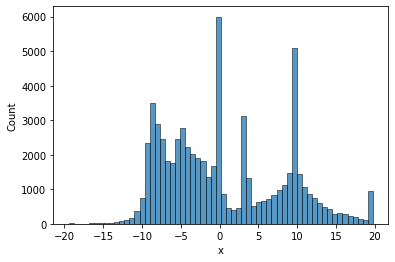

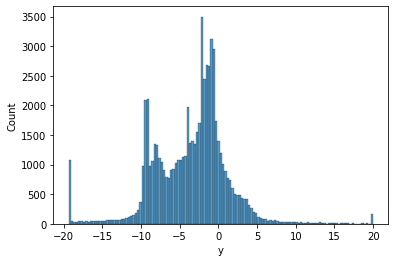

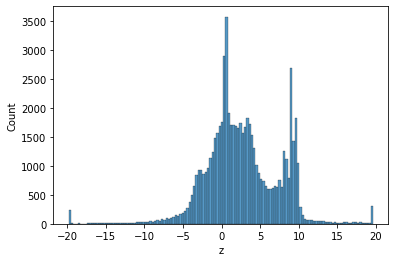

In [16]:
plt.figure()
sns.histplot(df.x)

plt.figure()
sns.histplot(df.y)

plt.figure()
sns.histplot(df.z)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


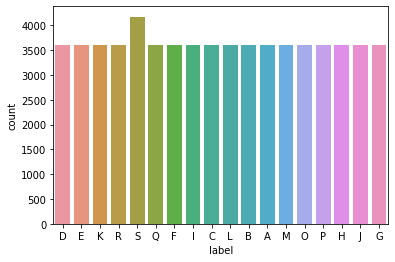

In [20]:
sns.countplot(df.label)

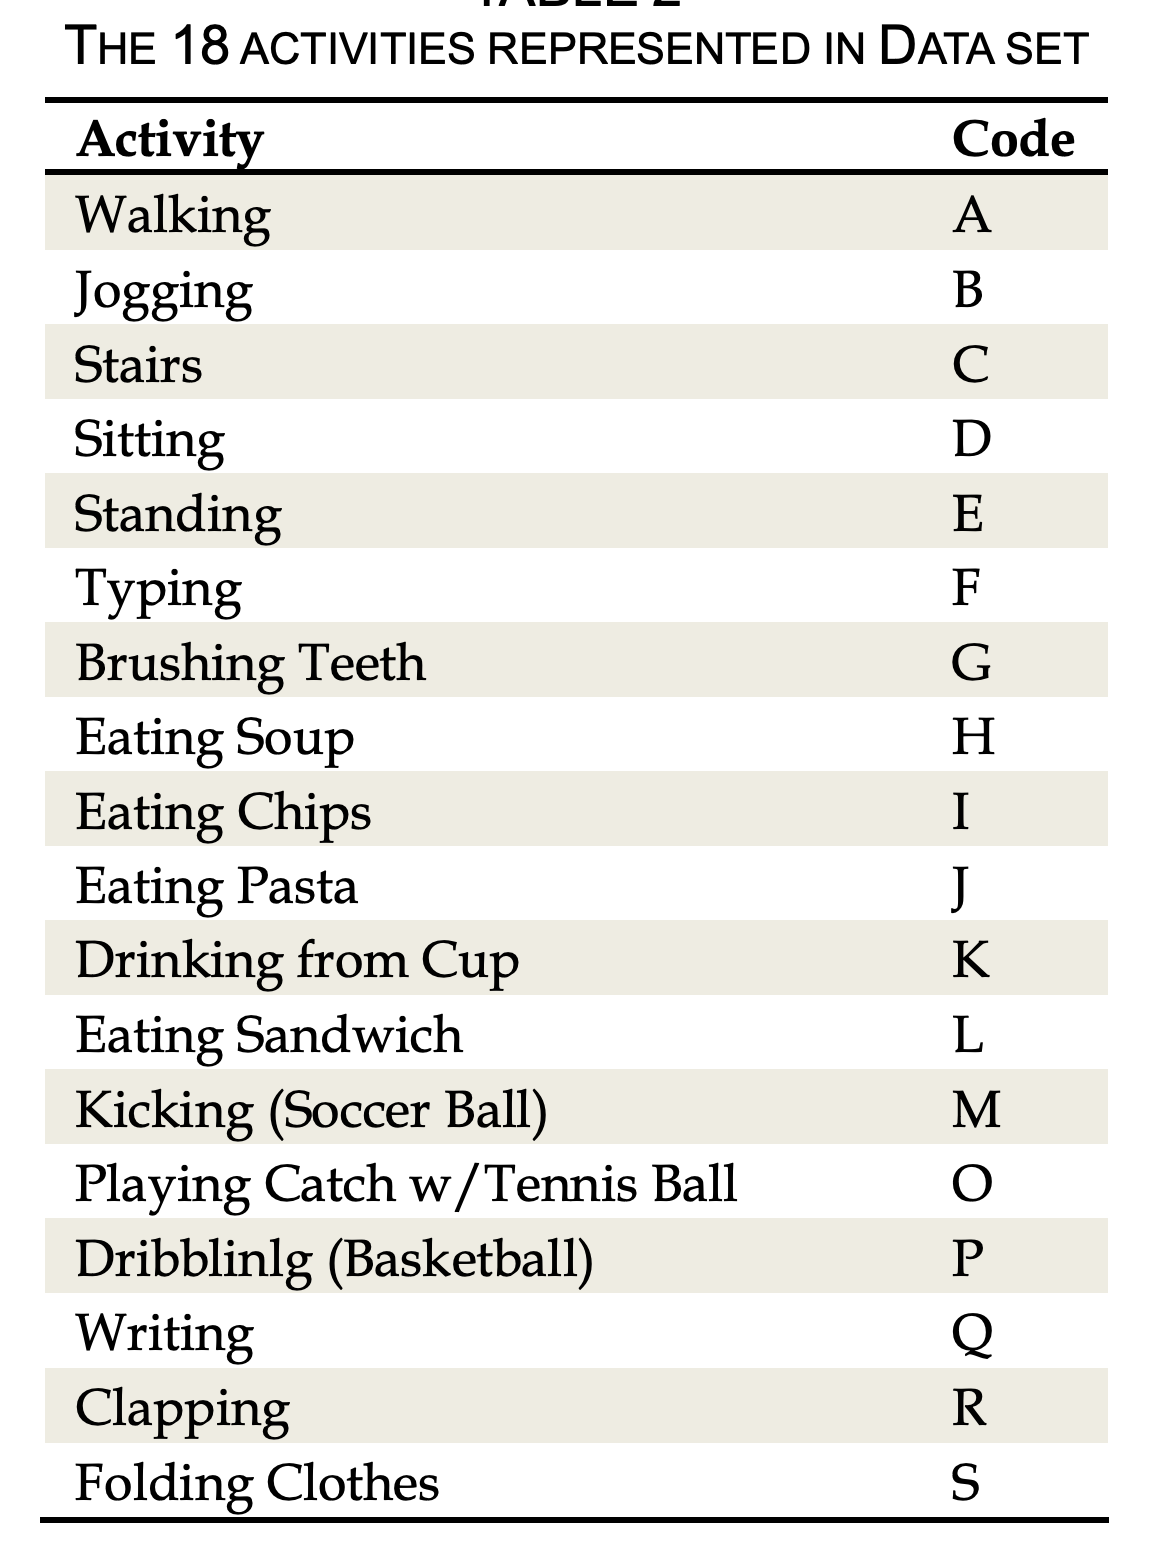

In [8]:
# display the label mappings
from IPython.display import Image
Image('classes.png', width=200, height=300)

Format of the data:
After exploring the downloaded dataset I have figured out the formatting. The downloaded dataset contains an individual file for each of the 51 subjects. The above data is read from a single subject's watch accelerometer and is completely raw, unprocessed data. The sampling rate is 20Hz, which we can see from the timestamp. Also, note that these readings include the force of gravity.


We see good distributions for each of the axes and we see that the classes are quite balanced for this particular subject. The paper indicates classes are balanced as well, since subjects spent equal time performing each activity. So, I will not check each of the 51 subjects.

# Data Preprocessing: 

Our data is currently a time series array of x, y, and z recordings. We need to break it into samples in order to train/test our model.

To do this, I will use 10 second rolling windows (overlapping) to create samples.

*Note: Here I began to realize that this project is more about the data preprocessing and compute limitations.*

I wrote this preprocessing code and then cleaned it up into functions. Here I started encountering problems with the Google Collab server's RAM. The server kept crashing so I modified my code to batch process parts of each subjects code. With this method my rolling window has a right edge starting at index 0, so the first X windows have nans and were dropped. This is commented below. This means that there are some missing segments that would have been completed if I had been able to read in all of the data at once for a subject.

In [7]:
import csv
import os

Here I manually implement rolling windows. Pandas does have a rolling window function (df.rolling(x) or df.groupby(y).rolling(x)) but this is designed to be an aggregation function (such as taking a rolling mean) rather than producing segments.

In [2]:
def grab_segments(s, window_size=200):
    # Helper function - manual rolling window
    arr = [list(s.shift(x).values[::-1][:window_size]) for x in range(len(s))[::-1]]
    return pd.Series(arr)
    
def segment_data(df):
  """
      Rolling window function.
      Accelerometer sensor sampling rate is 20 Hz. 
      So -- The number of recordings in our rolling window is
        20 recordings/second * 10 seconds = 200 total recordings
  """
  arrx = df.groupby('label').x.apply(grab_segments) # rolling window for X axis
  arry = df.groupby('label').y.apply(grab_segments) # rolling window for Y axis
  arrz = df.groupby('label').z.apply(grab_segments) # rolling window for Z axis

  arrx = arrx.reset_index()
  arry = arry.reset_index()
  arrz = arrz.reset_index()

  all = arrx.merge(arry, on=['label', 'level_1'])
  all = all.merge(arrz, on=['label', 'level_1'])
  return all

def run_preprocess(df):
  # add column headers based off documentation
  df.columns = ['SID', 'label', 'timestamp', 'x', 'y', 'z']

  # fix a little bug with loading this data file
  df['SID'] = df.iloc[0]['SID']

  # drop rows with nan (the reader reads a full nan row at the end of the df)
  df.drop(index=df[df.isna().any(axis=1)].index, inplace=True)

  df.set_index('timestamp', inplace=True)
  df.sort_index(inplace=True)

  all = segment_data(df)

  # drop the first 199 observations which will have nans due to the rolling window edges
  all.drop(index=[i for i in range(199)], inplace=True)

  # extract to multidimensional numpy array rather than nested numpy arrays
  x = np.array(all.x.tolist())
  y = np.array(all.y.tolist())
  z = np.array(all.z.tolist())

  labels = np.array(all.label.tolist())
  xyz = np.stack([x, y, z])

  # reshape the dimensions
  d0 = xyz.shape[0]
  d1 = xyz.shape[1]
  d2 = xyz.shape[2]

  xyz = np.reshape(xyz, (d1, d0, d2))
  
  # append preprocessed data to csv
  with open('data.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(xyz)

  with open('labels.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(labels)

In [10]:
files = os.listdir('wisdm-dataset/raw/watch/accel/')
print({f'Num subjects: {len(files) - 1}'})

{'Num subjects: 51'}


In [11]:
for fn in files[0:2]:
  print(f'Processing file: {fn}')
  try:
    iter = pd.read_csv('wisdm-dataset/raw/watch/accel/' + fn, header=None, lineterminator=';', iterator=True, chunksize=35000)
    for df in iter:
      run_preprocess(df)
    
  except:
    print(f'~~Error with file, skipping: {fn}~~')
    continue

Processing file: data_1619_accel_watch.txt
~~Error with file, skipping: data_1619_accel_watch.txt~~
Processing file: data_1624_accel_watch.txt
~~Error with file, skipping: data_1624_accel_watch.txt~~


In [3]:
def extract(t):
    t = t.replace('\n', ' ')
    t = np.array(t[1:-1].split())
    t = t.astype(float)
    return t

def return_iter(fn='data.csv', ln='labels.csv', batch_size=35000):
    iter_labels = pd.read_csv(ln, header=None, iterator=True, chunksize=batch_size)
    iter_data = pd.read_csv(fn, header=None, iterator=True, chunksize=batch_size)
    return iter_labels, iter_data

def read_data(data):
  # parse strings to floats
  t = data.apply(lambda x: x.apply(lambda x: extract(x)))

  x = np.array(t[0].tolist())
  y = np.array(t[1].tolist())
  z = np.array(t[2].tolist())

  xyz = np.stack([x, y, z])
  return xyz

In [69]:
possible_labels = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'O', 'P', 'Q', 'R', 'S'])
le.fit(possible_labels)

ohe = preprocessing.OneHotEncoder()
ohe.fit(possible_labels.reshape(1, -1))

OneHotEncoder()

In [30]:
# create data iterators to read from disk
iter_labels, iter_data = return_iter(fn='data.csv', ln='labels.csv', batch_size=35000)

batch_size = 35000
indexor = 0

for labels, data in zip(iter_labels, iter_data):
  extracted_data = read_data(data)
  extracted_data = np.reshape(extracted_data, (extracted_data.shape[1], 3, 200))

  labels = np.array(labels[0])

  # now split the data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(extracted_data, labels, test_size=0.33, random_state=42)

  # # write the train and test sets to separate files
  # os.mkdir('train')
  # os.mkdir('test')

  # for i in X_train.shape[0]:
  #   np.save(f'{indexor}_data', X_train[i])
  #   indexor+=1


  with open('xtrain.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(X_train)

  with open('ytrain.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(y_train)

  with open('xtest.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(X_test)

  with open('ytest.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(y_test)

## A comment about Pytorch dataset classes
I first tried to create a Pytorch Dataset class for this dataset. I had some trouble because the class needs two function implemented: len and getitem. Function getitem needs to take in an index and return the single data item at that index. 

My data setup is such that my code read in roughly half of each subjects' data at each iteration (because of the RAM limitations that I ran into while computing the rolling window segmentation). The data was segmented then appended to a csv file, which finally contained the processed data for all 51 subjects.

To implement getitem I would have to iteratively open this processed csv file and call the iterator and keep a counter to identify the object at the correct index. This seems really inefficient to me so I did a different approach. (I do plan to come back and get this to work later though!)

An alternative idea is to save each data item separately in a file system that would allow for more efficient indexing. I wanted to stay focused on the deep learning task so I decided to not create the dataset class. 

In [37]:
# import os
# import pandas as pd
# from torch.utils.data import Dataset
# from torchvision import datasets

# class AccelerometryDataset(Dataset):
#     def __init__(self, label_file, data_file, sklearn_target_transformer=None):
#         self.img_labels = pd.read_csv(label_file)
#         self.data_dir = data_file
#         self.target_transform = sklearn_target_transformer

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         #img_path = os.path.join(self.data_dir, self.img_labels.iloc[idx, 0])

#         segment = read_image(img_path)
#         label = self.img_labels.iloc[idx, 1]
#         if self.sklearn_target_transformer:
#             label = self.sklearn_target_transformer.transform(label)
#         return segment, label

## Now let's prepare the model

I use the package here (https://github.com/1adrianb/binary-networks-pytorch) to binarize the model. I define the model as usual then call a function from this package that binarizes the filters and inputs to layers.

In [12]:
! pip install bnn

  Using cached PyYAML-6.0-cp39-cp39-macosx_10_9_x86_64.whl (197 kB)
  Created wheel for bnn: filename=bnn-0.1.2-py2.py3-none-any.whl size=23002 sha256=3b9c6b98139885fdfed29da2b1a140208bd73292ca445b1494a2d21a1f235b4a
  Stored in directory: /Users/julialromero/Library/Caches/pip/wheels/78/fc/50/9c9f25162ac05d48e2a389d35df8a650ae55876216e76b3b20
  Created wheel for easydict: filename=easydict-1.10-py3-none-any.whl size=6506 sha256=375edb7dcd02ed9456ecfac01b9f9193d3da8915144bf04526e3d02c7ebf4e54
  Stored in directory: /Users/julialromero/Library/Caches/pip/wheels/0d/9a/a9/02f3a5f0c6b2c57184661770360c58db8166f5c877780e98f2
Successfully built bnn easydict


In [4]:
from bnn import BConfig, prepare_binary_model
import torch
import torchvision.models as models
from bnn.ops import BasicInputBinarizer, BasicScaleBinarizer, XNORWeightBinarizer
import torch
import torch.nn as nn

In [5]:
# define the binarizing process
bconfig = BConfig(
    activation_pre_process = BasicInputBinarizer,
    activation_post_process = BasicScaleBinarizer,
    weight_pre_process = XNORWeightBinarizer.with_args(center_weights=True)
)

In [6]:
# # Build a CNN architecture that has 10+ layers (this is important for the network to be deep in order to test batch norm).
class CNN_Original(nn.Module):
   def __init__(self):
        super(CNN_Original, self).__init__()

        torch.manual_seed(0)

        self.layers = nn.Sequential(
            nn.Conv1d(3, out_channels=16, kernel_size=3),
            nn.Conv1d(16, 32, 3),
            nn.ReLU(inplace=False),
            nn.Flatten(),
            nn.Linear(6272, 96),
            nn.Linear(96, 18),
            #nn.LogSoftmax(dim=1)
        )

   def forward(self, x):
       return self.layers(x)


In [7]:
# first I will pick an arbitrary model
#model = models.resnet18(weights=None)
model = CNN_Original()

# now binarize the network
bmodel = prepare_binary_model(model, bconfig)

In [8]:
# examine the architecture
bmodel

CNN_Original(
  (layers): Sequential(
    (0): Conv1d(
      3, 16, kernel_size=(3,), stride=(1,)
      (activation_pre_process): BasicInputBinarizer()
      (activation_post_process): BasicScaleBinarizer([1, 16, 1])
      (weight_pre_process): XNORWeightBinarizer()
    )
    (1): Conv1d(
      16, 32, kernel_size=(3,), stride=(1,)
      (activation_pre_process): BasicInputBinarizer()
      (activation_post_process): BasicScaleBinarizer([1, 32, 1])
      (weight_pre_process): XNORWeightBinarizer()
    )
    (2): ReLU()
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(
      in_features=6272, out_features=96, bias=True
      (activation_pre_process): BasicInputBinarizer()
      (activation_post_process): BasicScaleBinarizer([1, 96])
      (weight_pre_process): XNORWeightBinarizer()
    )
    (5): Linear(
      in_features=96, out_features=18, bias=True
      (activation_pre_process): BasicInputBinarizer()
      (activation_post_process): BasicScaleBinarizer([1, 18])
      (weig

By examining the printed architecture we see that there are pre and post processing done at each convolutional and fully connected layer. Additionally we see that the weights at each layer are binarized.

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bmodel = bmodel.to(device)

In [10]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(bmodel.parameters(), lr=0.01)

### Class Label processing
 One Hot Encode the classes, since our architecture has a softmax at the output. The idea is to push the model's output vector (dims 1x18) to be as close to the 1x18 one hot encoded vector during training. Then we evaluate by taking the indexed max of that output vector to get the class with the highest probability as determined by the model.

In [11]:
possible_labels = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'O', 'P', 'Q', 'R', 'S']).reshape(-1, 1)


ohe = preprocessing.OneHotEncoder()
ohe.fit(possible_labels)

OneHotEncoder()

Since I did not create the Pytorch data class I figured out how to load the data in batches by creating an csv iterator reader with a batch size of 300. Again this was a pretty small batch because I wanted to avoid the runtime crashing. 

In [ ]:
from tqdm import tqdm

train_loss_epoch = []

iter_labels, iter_data = return_iter(fn='xtrain.csv', ln='ytrain.csv', batch_size=100)


for epoch in range(0, 2):
  current_loss = 0
  for i, (inputs, targets) in tqdm(enumerate(zip(iter_data, iter_labels))):
    # load data
    inputs = read_data(inputs)
   
    # load targets
    targets = np.array(targets[0]).reshape(-1, 1)
    targets = ohe.transform(targets).toarray()  #le

    targets = torch.from_numpy(targets)
    inputs2 = torch.from_numpy(inputs).reshape(inputs.shape[1], 3, 200)

    optimizer.zero_grad()
    outputs = bmodel(inputs2.float())#.reshape(300)

    loss = loss_func(outputs, targets)
    loss.backward()   # propogate backwards
    optimizer.step()

    current_loss += loss.item()

    if i % 500 == 499:
        print('---Mini Batch Loss---')
        print('Train: %5d: %.3f' % (i + 1, current_loss/500))
        train_loss_epoch.append(current_loss/i)

        current_loss = 0


0it [00:00, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(train_loss_epoch))], train_loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epoch')

In [210]:
# Use on test set
correct = 0
total = 0

iter_labels, iter_data = return_iter(fn='xtest.csv', ln='ytest.csv', batch_size=5000)

with torch.no_grad():
    for targets, inputs in zip(iter_labels, iter_data):
      # load data
      inputs = read_data(inputs)
    
      # load targets
      targets = np.array(targets[0]).reshape(-1, 1)
      targets = le.transform(targets)#.toarray()  #le

      targets = torch.from_numpy(targets)
      inputs2 = torch.from_numpy(inputs).reshape(inputs.shape[1], 3, 200)

      outputs = model(inputs2.float())

      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

print(f'Model Accuracy on test set: {100 * correct // total} %')

Model Accuracy on test set: 55.00000000000001 %


# Conclusion
I ran out of time to train the network fully and explore its performance. I was really interested in trying out an application in signal processing but there was a lack of curated datasets, so I put effort into the data preparation over the model development. 

I tried to run it on my laptop computer CPU (since the model is binarized and is CPU friendly) but my kernel immediately died each time I tried to run the model training loop. This overrode some of the output from my successful run on Google Collab (the training plot and printed loss), but you can see the final output accuracy of ~55%. This is pretty decent given that there are 18 classes!

I would like to continue to work on this problem in the future. I am open to any suggestions for getting around compute limitations. Thanks!